ประกาศตัวแปร

In [2]:
ROOT_PATH = "~/ChestXray-14/results/confusion"

เลือกโมเดลที่ต้องการ

In [149]:
fold_num = 1
model_name = f"DenseNet121_None_fold_{fold_num}"

อ่านจากไฟล์ประวัติ Threshold เทียบกับ Confusion metrics ของแต่ละโมเดล

In [150]:
import numpy as np
import pandas as pd
from modules.dataset import LABELS

In [151]:
def preprocessing_data(x):
    if "e+" in x:
        values = eval(x.replace(" ", ", "))
        return np.array(values)
    else:
        values = eval(x.replace("\n", "").replace(". ", ".,"))
        return np.array(values)

In [152]:
df = pd.read_csv(f"{ROOT_PATH}/{model_name}.csv")
thresholds = df["thresholds"].values
TP = df["TP"].apply(preprocessing_data).values
TN = df["TN"].apply(preprocessing_data).values
FP = df["FP"].apply(preprocessing_data).values
FN = df["FN"].apply(preprocessing_data).values

แสดงผล

In [153]:
f1_thresholds_dict = dict()
for i_thresh, (tps, tns, fps, fns) in enumerate(zip(TP, TN, FP, FN)):
    for label, tp, tn, fp, fn in zip(LABELS, tps, tns, fps, fns):
        f1_score = 2*tp / (2*tp + fp + fn)
        try: 
            f1_thresholds_dict[label].append((thresholds[i_thresh], f1_score))
        except:
            f1_thresholds_dict[label] = [(thresholds[i_thresh], f1_score)]

In [154]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [184]:
def plot_compare(dictionary, name, x_label, y_label):
    plt.figure(figsize=(20,12))
    best_multiple_f1_list = []
    for i, (label, value) in enumerate(dictionary.items()):
        x, y = zip(*value)
        plt.plot(x, y, marker='.', label=label)
        
        y = np.array(y)
        best = y.argmax()
        sns.scatterplot(x=[x[best]], y=[y[best]], marker="X", s=300)
        
        best_multiple_f1_list.append(x[y.argmax()])

    plt.title(name)
    plt.legend()
    plt.xlabel(x_label, fontweight='bold')
    plt.ylabel(y_label, fontweight='bold')
    plt.ylim(-0.05, 1.05)
    plt.xlim(-0.05, 1.05)
    plt.show()
    return best_multiple_f1_list

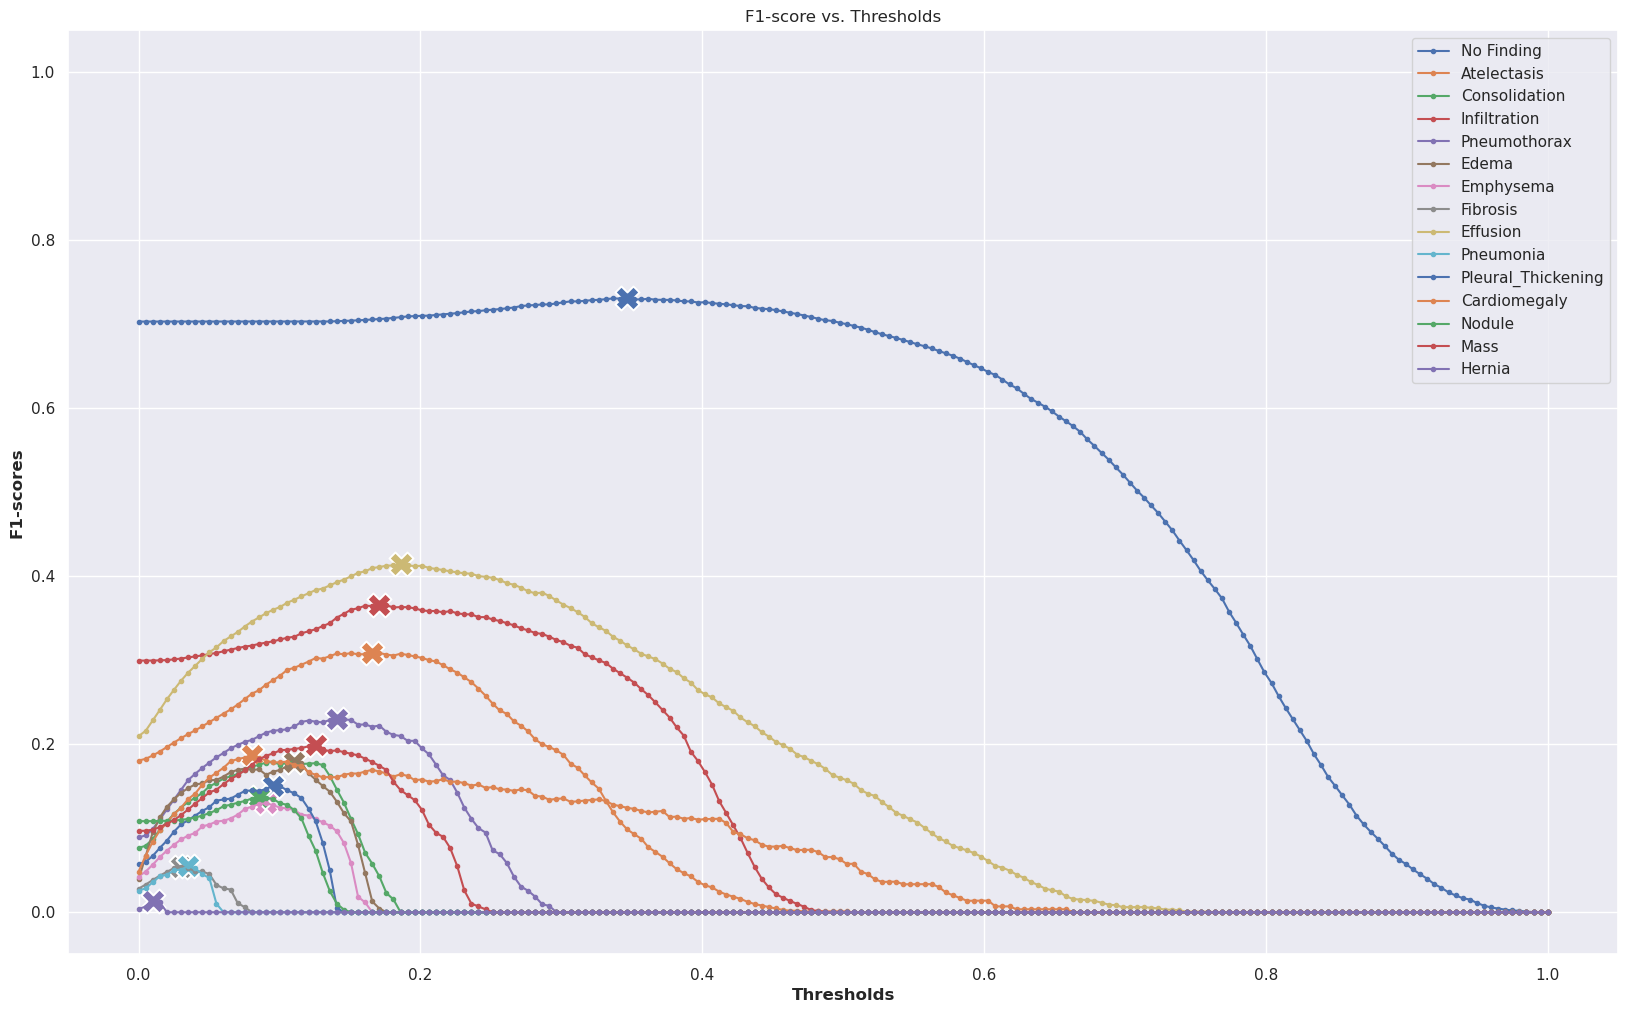

In [186]:
best_multiple_threshold = plot_compare(f1_thresholds_dict, name="F1-score vs. Thresholds", x_label='Thresholds', y_label='F1-scores')

In [189]:
best_multiple_threshold

[0.3467336683417085,
 0.1658291457286432,
 0.1105527638190954,
 0.1708542713567839,
 0.1407035175879397,
 0.1105527638190954,
 0.0904522613065326,
 0.0301507537688442,
 0.185929648241206,
 0.0351758793969849,
 0.0954773869346733,
 0.0804020100502512,
 0.0854271356783919,
 0.1256281407035175,
 0.0100502512562814]

ลองทำนายด้วยค่า Multiple threshold

In [192]:
def get_y_true(data):
    y_true=[]
    for X,y in data:
        for label in y:
            y_true.append(label)
    y_true = tf.Variable(y_true)
    return y_true

In [194]:
import tensorflow as tf
from modules.dataset import Dataset

In [195]:
dataset = Dataset()

# Dataset
train_dataset, test_dataset = dataset.get_kfold(fold_num, sample=False)

# Get y_true
y_true = get_y_true(test_dataset)

# Modeling
model = tf.keras.models.load_model(f"results/models/{model_name}.h5")

2022-11-30 07:20:03.083235: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-30 07:20:03.806578: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8013 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 2g.10gb, pci bus id: 0000:ca:00.0, compute capability: 8.0


In [196]:
y_preds = model.predict(test_dataset)

2022-11-30 07:20:27.985135: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-11-30 07:20:28.951672: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-30 07:20:28.953602: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-30 07:20:28.953703: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-11-30 07:20:28.955029: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-30 07:20:28.955238: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


      4/Unknown - 6s 45ms/step

2022-11-30 07:20:30.875744: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1402/1402 [==============================] - 62s 40ms/step


In [197]:
y_preds

array([[0.4336083 , 0.13768736, 0.01926378, ..., 0.10413095, 0.0845392 ,
        0.00988945],
       [0.5345452 , 0.14267938, 0.07294688, ..., 0.04815441, 0.0515449 ,
        0.00093183],
       [0.5442906 , 0.24424972, 0.02617655, ..., 0.04397687, 0.02664268,
        0.00890344],
       ...,
       [0.5319146 , 0.05115867, 0.02044028, ..., 0.07014855, 0.01822055,
        0.00367277],
       [0.21888576, 0.27319917, 0.14816466, ..., 0.05400639, 0.05675362,
        0.0025761 ],
       [0.32348573, 0.10425596, 0.06829778, ..., 0.12067325, 0.11936656,
        0.00523995]], dtype=float32)

In [198]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.2 MB/s eta 0:00:00a 0:00:01


In [207]:
best_multiple_threshold

[0.3467336683417085,
 0.1658291457286432,
 0.1105527638190954,
 0.1708542713567839,
 0.1407035175879397,
 0.1105527638190954,
 0.0904522613065326,
 0.0301507537688442,
 0.185929648241206,
 0.0351758793969849,
 0.0954773869346733,
 0.0804020100502512,
 0.0854271356783919,
 0.1256281407035175,
 0.0100502512562814]

In [208]:
import seaborn as sns
from modules.dataset import LABELS
import matplotlib.pyplot as plt

def plot_confusion_metics(confusion_metrics, threshold):
    fig = plt.figure(figsize=(35,20))
    fig.suptitle(f"Condusion Metrics for Threshold: {threshold[:5]}\n{threshold[5:10]}\n{threshold[10:]}", fontsize=30)
    for i, confusion_metrix in enumerate(confusion_metrics.numpy().astype('int64')):
        plt.subplot(3, 5, i+1)
        plt.title(LABELS[i], fontweight='bold', fontsize=16)
        sns.heatmap(confusion_metrix, cbar=False, annot=True, fmt="d", cmap="Greens", linewidths=.5, annot_kws={"fontsize":24})
        plt.xlabel('"Prediction"', fontweight='bold')
        plt.ylabel('"Actual"', fontweight='bold')

In [209]:
import numpy as np
import tensorflow_addons as tfa

def run_confusion_metrics():
    fig = plt.figure(figsize=(35,20))
    thresh_value = best_multiple_threshold
    metric = tfa.metrics.MultiLabelConfusionMatrix(num_classes=15)
    metric.update_state(y_true,
                        np.greater_equal(y_preds, thresh_value).astype('int8'))
    result = metric.result()
    plot_confusion_metics(result, thresh_value)
    plt.show()

<Figure size 3500x2000 with 0 Axes>

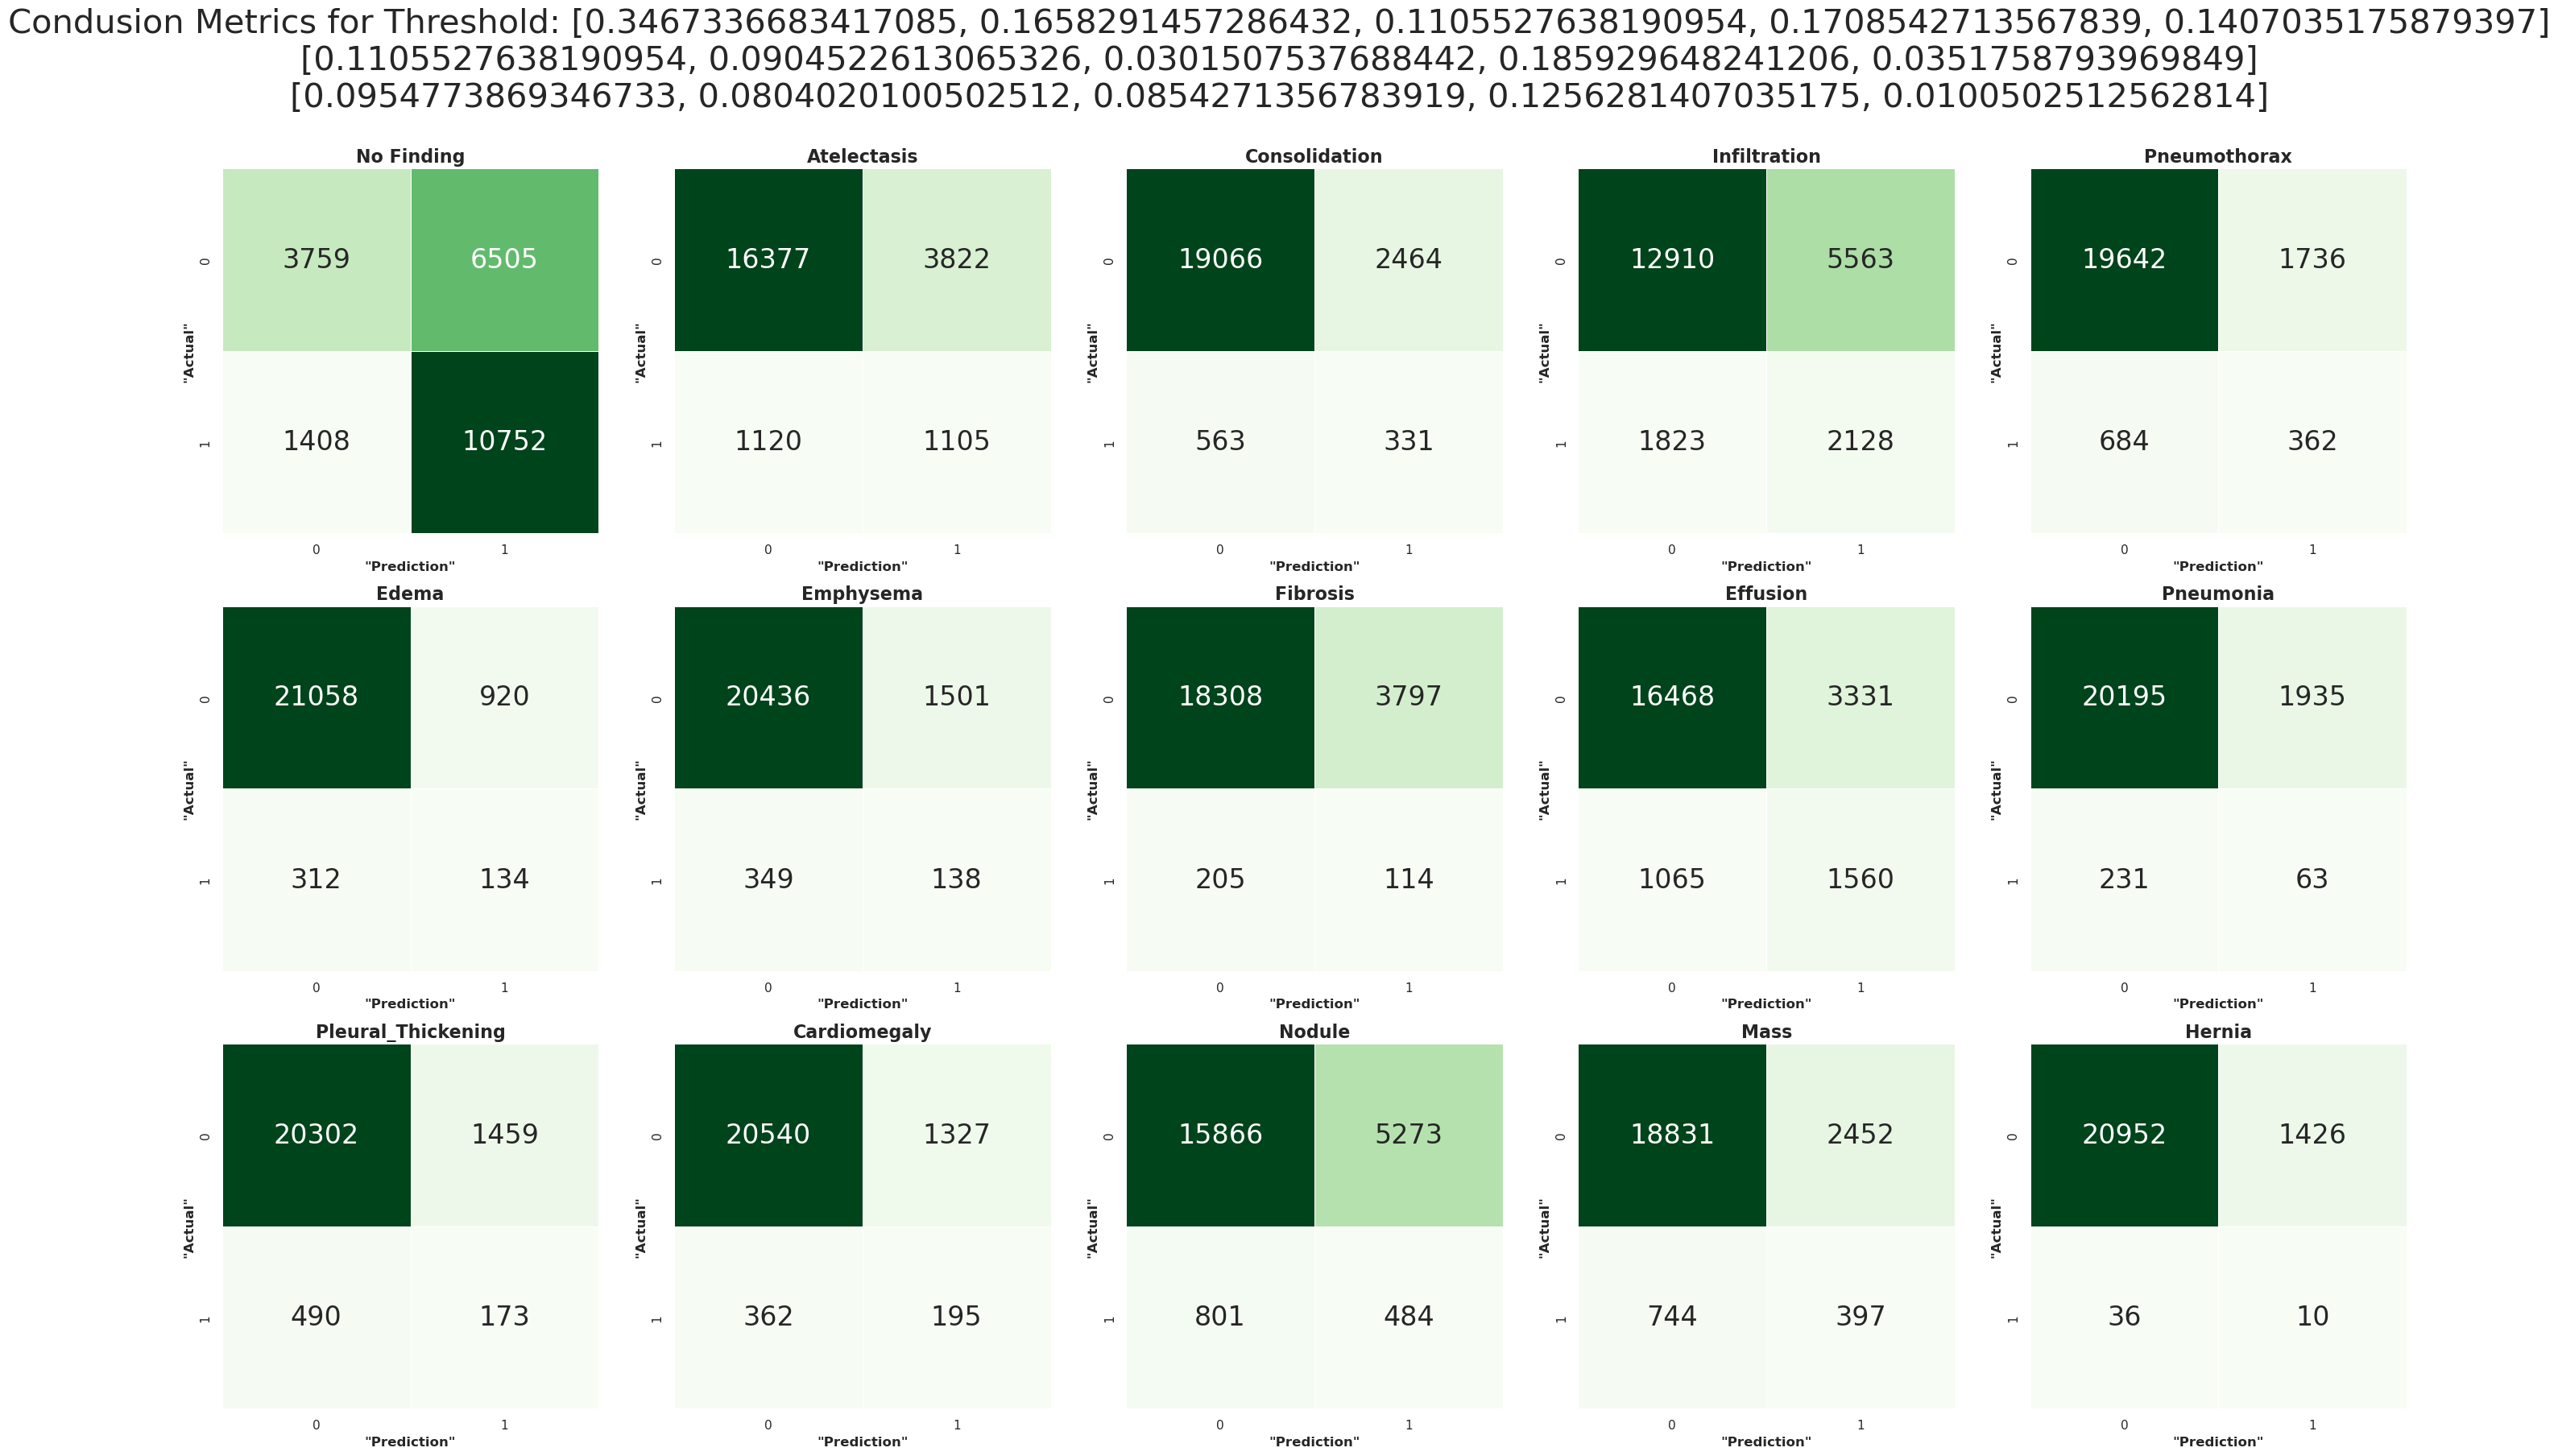

In [210]:
run_confusion_metrics()